In [1]:
import torch
import numpy as np
from qibo import Circuit, gates
import matplotlib.pyplot as plt

In [2]:
# ----------- Quantum circuit builder -----------
def build_circuit(x_input, theta):
    circuit = Circuit(1)
    
    # Prepare input state
    if x_input == 1:  # |+⟩ = H|0⟩
        circuit.add(gates.H(0))
    else:
        pass  # |0⟩ is already default
    # Trainable rotation
    circuit.add(gates.RY(0, theta))

    # Measure
    circuit.add(gates.M(0))
    
    return circuit
    

# ----------- Simple Training Loop (PyTorch Optimizer) -----------
class QuantumModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        init_param = np.round(np.random.uniform(0, 2*np.pi), 5)
        self.theta = torch.nn.Parameter(torch.tensor([init_param], dtype=torch.float32))

    def forward(self, x_input):
        circuit = build_circuit(x_input, self.theta.item())
        return circuit

In [3]:
class Client:
    def __init__(self, num_samples, seed, vqc_class=QuantumModel, sigma=0, target_class0_ratio=None, n_shots=1):
        
        self.num_samples = num_samples
        self.seed = seed       
        self.model = vqc_class()
        self.sigma = sigma
        self.target_class0_ratio = target_class0_ratio
        self.labels = self._generate_labels()
        self.sample_pointer = 0  
        self.local_weights_evolution = []
        self.n_shots = n_shots  # Number of shots for gradient calculation
        

    def _generate_labels(self):
        """
        Generate labels for this client with class imbalance based on sigma.
        """
        np.random.seed(self.seed)
        
        if self.target_class0_ratio is not None:
            num_class0 = int(round(self.num_samples * self.target_class0_ratio))
            num_class1 = self.num_samples - num_class0
            labels = np.array([0] * num_class0 + [1] * num_class1)
            np.random.shuffle(labels)
        else:
            raw_bias = np.random.normal(0, self.sigma)
            prob_class_0 = 1 / (1 + np.exp(-raw_bias))  # sigmoid
            labels = np.random.choice([0, 1], size=self.num_samples, p=[prob_class_0, 1 - prob_class_0])
    
        return labels
        

    def get_label_distribution(self):
        """
        Returns the proportion of class 0 and class 1.
        """
        prop_class_0 = np.mean(self.labels == 0)
        prop_class_1 = 1 - prop_class_0
        return {'class_0': prop_class_0, 'class_1': prop_class_1}
        

    def set_theta(self, new_theta):
        with torch.no_grad():
            self.model.theta.copy_(torch.tensor(new_theta, dtype=torch.float64))

    
    def get_theta(self):
        return self.model.theta.detach().numpy()


    # def compute_grad(self, x_input, theta, label, shift=np.pi/2):
    #     grad = parameter_shift_grad(x_input=x_input, theta=theta, label=label, shift=shift, n_shots=self.n_shots)
    #     return grad
            

    def local_train(self, batch_size, lr=0.1):

        # Select next batch
        start = self.sample_pointer
        end = min(start + batch_size, self.num_samples)
        self.sample_pointer = end
    
        if end - start == 0:
            return self.get_theta()  # No more data

        training_data = self.labels[start:end]
        theta_history = []
        grads = []
    
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        #optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        #loss_fn = nn.BCELoss()

        local_weights_evolution_aux = []
        
        for epoch, label in enumerate(training_data):
            #print("LABEL USED:", label)
            x_input = label
            optimizer.zero_grad()
        
            # Estimate gradient via parameter-shift
            grad_estimate = parameter_shift_grad(x_input, self.model.theta.item(), label, n_shots=self.n_shots)
            grads.append(grad_estimate)
            
            # Manually assign gradient to parameter
            self.model.theta.grad = torch.tensor([grad_estimate], dtype=torch.float32)
        
            optimizer.step()
        
            # Track accuracy and current value
            #prediction = self.model(x_input)
            #correct = (prediction == label)
            #theta_history.append(np.round(self.model.theta.item(), 4))
            #print(f"Epoch {epoch:03d} | x={x_input} | Label={label} | Pred={prediction} | θ={self.model.theta.item():.4f} | Correct={correct}")
            theta = self.get_theta().copy()
            #print("Updated parameters to:",theta[0])
            local_weights_evolution_aux.append(theta[0])
        self.local_weights_evolution.append(local_weights_evolution_aux)
    
        return self.get_theta()

In [4]:
def compute_Psuccess(client):
    Ps0 = client.model(0)(nshots=None).probabilities()[0]
    Ps1 = client.model(1)(nshots=None).probabilities()[1]

    Psuc = 0.5 * (Ps0 + Ps1)
    return Psuc

In [5]:
optimal_client = Client(None, None)
optimal_client.set_theta(np.pi/4)
optimal_Psuc = compute_Psuccess(optimal_client)
optimal_Psuc

[Qibo 0.2.20|INFO|2026-02-02 15:51:51]: Using numpy backend on /CPU:0


np.float64(0.8535533905932735)

In [6]:
import re
import os

data_s0 = {}

# Loop through exp1_s0.txt to exp5_s0.txt
for i in range(1, 11):
    filename = f"./setup3/exp{i}_s0.txt"
    if os.path.exists(filename):
        with open(filename) as f:
            text = f.read()
        data_s0[f"exp{i}_s0"] = [float(x) for x in re.findall(r"-?\d+\.\d+(?:e-?\d+)?", text)]
        print(f"{filename}: {len(data_s0[f'exp{i}_s0'])} floats loaded.")
    else:
        print(f"⚠️ File not found: {filename}")

./setup3/exp1_s0.txt: 25 floats loaded.
./setup3/exp2_s0.txt: 25 floats loaded.
./setup3/exp3_s0.txt: 25 floats loaded.
./setup3/exp4_s0.txt: 25 floats loaded.
./setup3/exp5_s0.txt: 25 floats loaded.
./setup3/exp6_s0.txt: 25 floats loaded.
./setup3/exp7_s0.txt: 25 floats loaded.
./setup3/exp8_s0.txt: 25 floats loaded.
./setup3/exp9_s0.txt: 25 floats loaded.
./setup3/exp10_s0.txt: 25 floats loaded.


In [7]:
mean_SCPsuc_exps_s0 = []

for exp in ["exp1_s0", "exp2_s0", "exp3_s0", "exp4_s0", "exp5_s0", "exp6_s0", "exp7_s0", "exp8_s0", "exp9_s0", "exp10_s0"]:
    ona_Psucs = []
    for theta in data_s0[exp]:
        client = Client(None, None)
        client.set_theta(theta)
        client_Psuc = compute_Psuccess(client)
        ona_Psucs.append(client_Psuc)
        
    print(f"Mean SC Psuc for {exp}: {np.mean(ona_Psucs)}")
    mean_SCPsuc_exps_s0.append(np.mean(ona_Psucs))

Mean SC Psuc for exp1_s0: 0.6854786873997483
Mean SC Psuc for exp2_s0: 0.6673620558939828
Mean SC Psuc for exp3_s0: 0.7094229656067477
Mean SC Psuc for exp4_s0: 0.6695263341388197
Mean SC Psuc for exp5_s0: 0.7789574083107285
Mean SC Psuc for exp6_s0: 0.6672028838305012
Mean SC Psuc for exp7_s0: 0.6432001770278069
Mean SC Psuc for exp8_s0: 0.7620930506493023
Mean SC Psuc for exp9_s0: 0.7491607427972972
Mean SC Psuc for exp10_s0: 0.6706931969020812


In [8]:
print(f"OVERALL MEAN SC-Psuc: {np.mean(mean_SCPsuc_exps_s0)}")

OVERALL MEAN SC-Psuc: 0.7003097502557016


In [9]:
def average_angles_modulo(weights_list):
    angles = np.array(weights_list)
    x = np.cos(angles)
    y = np.sin(angles)

    mean_x = np.mean(x)
    mean_y = np.mean(y)

    mean_angle = np.arctan2(mean_y, mean_x)
    return mean_angle % (2 * np.pi)

In [10]:
QFLPsuc_exps_s0 = []

for exp in ["exp1_s0", "exp2_s0", "exp3_s0", "exp4_s0", "exp5_s0", "exp6_s0", "exp7_s0", "exp8_s0", "exp9_s0", "exp10_s0"]:
    averaged_theta = average_angles_modulo(data_s0[exp])
    QFL_client = Client(None, None)
    QFL_client.set_theta(averaged_theta)
    QFL_Psuc = compute_Psuccess(QFL_client)
    print(f"QFL Psuc for {exp}: {QFL_Psuc}")
    QFLPsuc_exps_s0.append(QFL_Psuc)

QFL Psuc for exp1_s0: 0.8469657518214
QFL Psuc for exp2_s0: 0.8338294844554537
QFL Psuc for exp3_s0: 0.8534270048889636
QFL Psuc for exp4_s0: 0.8401036021743254
QFL Psuc for exp5_s0: 0.849458332327413
QFL Psuc for exp6_s0: 0.8513410834726802
QFL Psuc for exp7_s0: 0.8535459176309463
QFL Psuc for exp8_s0: 0.8535496028257419
QFL Psuc for exp9_s0: 0.8513341007733304
QFL Psuc for exp10_s0: 0.8462984733470335


In [11]:
print(f"OVERALL MEAN QFL-Psuc: {np.mean(QFLPsuc_exps_s0)}")

OVERALL MEAN QFL-Psuc: 0.8479853353717287


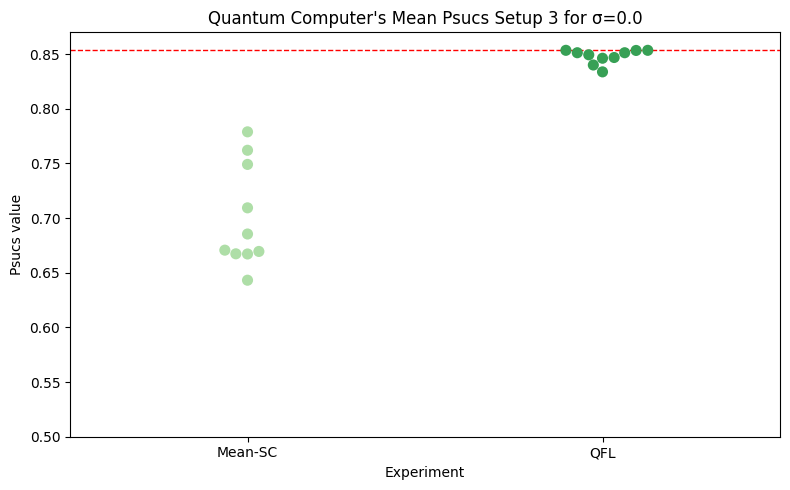

In [12]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "Psucs": mean_SCPsuc_exps_s0 + QFLPsuc_exps_s0,
    "Experiment": ["Mean-SC"] * len(mean_SCPsuc_exps_s0) + ["QFL"] * len(QFLPsuc_exps_s0)
})

plt.figure(figsize=(8, 5))
sns.swarmplot(
    x="Experiment", 
    y="Psucs", 
    hue="Experiment", 
    data=df, 
    palette="Greens", 
    size=8, 
    legend=False  # suppress the redundant legend
)

plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)
plt.ylim(0.5, 0.87)
plt.xlabel("Experiment")
plt.ylabel("Psucs value")
plt.title("Quantum Computer's Mean Psucs Setup 3 for σ=0.0")
plt.tight_layout()
plt.show()


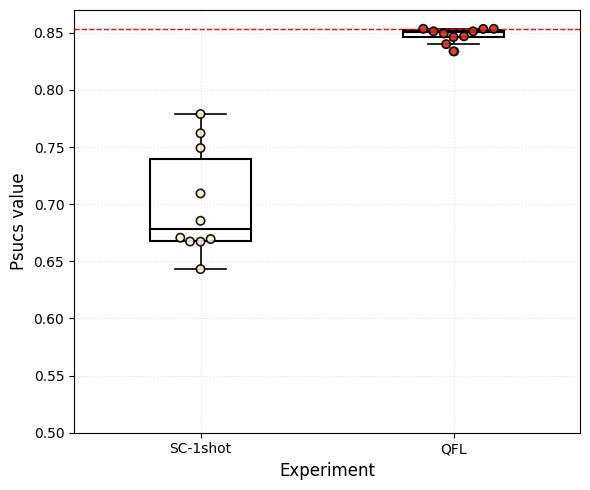

In [13]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "Psucs": mean_SCPsuc_exps_s0 + QFLPsuc_exps_s0,
    "Experiment": ["SC-1shot"] * len(mean_SCPsuc_exps_s0) + ["QFL"] * len(QFLPsuc_exps_s0)
})

plt.figure(figsize=(6, 5))

# Boxplot: hollow boxes
sns.boxplot(
    x="Experiment",
    y="Psucs",
    hue="Experiment",
    data=df,
    palette={"SC-1shot":"#fef0d9", "QFL":"#d7301f"},  # still needed for line colors
    width=0.4,
    showcaps=True,
    boxprops=dict(facecolor="none", edgecolor="black", linewidth=1.5),
    medianprops=dict(color="black", linewidth=1.5),
    whiskerprops=dict(color="black", linewidth=1.2),
    capprops=dict(color="black", linewidth=1.2),
    dodge=False,
    showfliers=True,
    legend=False
)

# Overlay actual points: hollow circles
sns.swarmplot(
    x="Experiment",
    y="Psucs",
    data=df,
    hue="Experiment",
    palette={"SC-1shot":"#fef0d9", "QFL":"#d7301f"},
    dodge=False,
    size=6,
    edgecolor="black",
    facecolor="none",
    linewidth=1.2,
    alpha=0.9,
    legend=False
)

# Reference line
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)

plt.ylim(0.5, 0.87)
plt.xlabel("Experiment", fontsize=12)
plt.ylabel("Psucs value", fontsize=12)
# plt.title("Quantum Computer's Mean Psucs Setup 4 for σ=0.0", fontsize=13)
plt.tight_layout()
plt.grid(True, linestyle=":", alpha=0.3)
plt.savefig("BSC_QC_sigma0.png", dpi=600, bbox_inches="tight")
plt.show()

In [14]:
import re
import os

data_s4 = {}

# Loop through exp1_s0.txt to exp5_s0.txt
for i in range(1, 11):
    filename = f"./setup3/exp{i}_s4.txt"
    if os.path.exists(filename):
        with open(filename) as f:
            text = f.read()
        data_s4[f"exp{i}_s4"] = [float(x) for x in re.findall(r"-?\d+\.\d+(?:e-?\d+)?", text)]
        print(f"{filename}: {len(data_s4[f'exp{i}_s4'])} floats loaded.")
    else:
        print(f"⚠️ File not found: {filename}")

./setup3/exp1_s4.txt: 25 floats loaded.
./setup3/exp2_s4.txt: 25 floats loaded.
./setup3/exp3_s4.txt: 25 floats loaded.
./setup3/exp4_s4.txt: 25 floats loaded.
./setup3/exp5_s4.txt: 25 floats loaded.
./setup3/exp6_s4.txt: 25 floats loaded.
./setup3/exp7_s4.txt: 25 floats loaded.
./setup3/exp8_s4.txt: 25 floats loaded.
./setup3/exp9_s4.txt: 25 floats loaded.
./setup3/exp10_s4.txt: 25 floats loaded.


In [15]:
mean_SCPsuc_exps_s4 = []

for exp in ["exp1_s4", "exp2_s4", "exp3_s4", "exp4_s4", "exp5_s4", "exp6_s4", "exp7_s4", "exp8_s4", "exp9_s4", "exp10_s4"]:
    ona_Psucs = []
    for theta in data_s4[exp]:
        client = Client(None, None)
        client.set_theta(theta)
        client_Psuc = compute_Psuccess(client)
        ona_Psucs.append(client_Psuc)
        
    print(f"Mean SC Psuc for {exp}: {np.mean(ona_Psucs)}")
    mean_SCPsuc_exps_s4.append(np.mean(ona_Psucs))

Mean SC Psuc for exp1_s4: 0.7274036579596168
Mean SC Psuc for exp2_s4: 0.6531043080743621
Mean SC Psuc for exp3_s4: 0.660940422609161
Mean SC Psuc for exp4_s4: 0.7354054379909187
Mean SC Psuc for exp5_s4: 0.6831684866711967
Mean SC Psuc for exp6_s4: 0.6491107376918975
Mean SC Psuc for exp7_s4: 0.580429917555771
Mean SC Psuc for exp8_s4: 0.739747421328423
Mean SC Psuc for exp9_s4: 0.7141216605026964
Mean SC Psuc for exp10_s4: 0.7026948420115912


In [16]:
print(f"OVERALL MEAN SC-Psuc: {np.mean(mean_SCPsuc_exps_s4)}")

OVERALL MEAN SC-Psuc: 0.6846126892395634


In [17]:
def average_angles_modulo(weights_list):
    angles = np.array(weights_list)
    x = np.cos(angles)
    y = np.sin(angles)

    mean_x = np.mean(x)
    mean_y = np.mean(y)

    mean_angle = np.arctan2(mean_y, mean_x)
    return mean_angle % (2 * np.pi)

In [18]:
QFLPsuc_exps_s4 = []

for exp in ["exp1_s4", "exp2_s4", "exp3_s4", "exp4_s4", "exp5_s4", "exp6_s4", "exp7_s4", "exp8_s4", "exp9_s4", "exp10_s4"]:
    averaged_theta = average_angles_modulo(data_s4[exp])
    QFL_client = Client(None, None)
    QFL_client.set_theta(averaged_theta)
    QFL_Psuc = compute_Psuccess(QFL_client)
    print(f"QFL Psuc for {exp}: {QFL_Psuc}")
    QFLPsuc_exps_s4.append(QFL_Psuc)

QFL Psuc for exp1_s4: 0.8531071384915998
QFL Psuc for exp2_s4: 0.8456236786519347
QFL Psuc for exp3_s4: 0.8476196952841968
QFL Psuc for exp4_s4: 0.838281274771922
QFL Psuc for exp5_s4: 0.8408754036849809
QFL Psuc for exp6_s4: 0.8525371002697227
QFL Psuc for exp7_s4: 0.7493486731006942
QFL Psuc for exp8_s4: 0.8510829762911309
QFL Psuc for exp9_s4: 0.8447845924468946
QFL Psuc for exp10_s4: 0.8387718975301535


In [19]:
print(f"OVERALL MEAN QFL-Psuc: {np.mean(QFLPsuc_exps_s4)}")

OVERALL MEAN QFL-Psuc: 0.8362032430523231


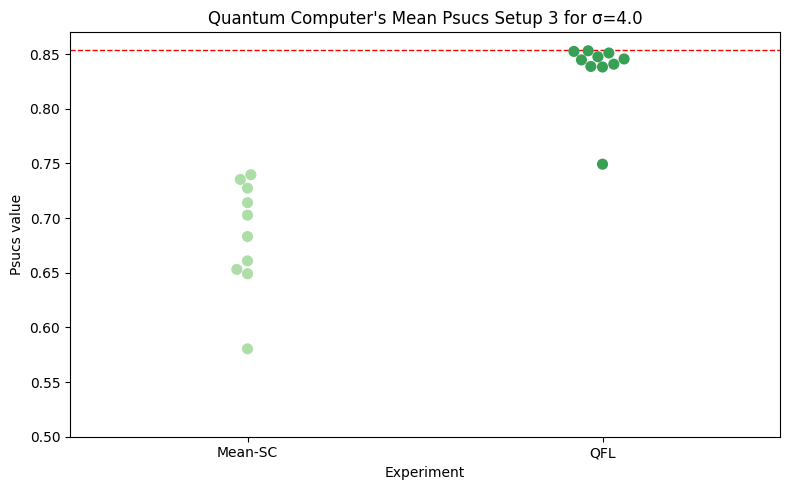

In [20]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "Psucs": mean_SCPsuc_exps_s4 + QFLPsuc_exps_s4,
    "Experiment": ["Mean-SC"] * len(mean_SCPsuc_exps_s4) + ["QFL"] * len(QFLPsuc_exps_s4)
})

plt.figure(figsize=(8, 5))
sns.swarmplot(
    x="Experiment", 
    y="Psucs", 
    hue="Experiment", 
    data=df, 
    palette="Greens", 
    size=8, 
    legend=False  # suppress the redundant legend
)

plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)
plt.ylim(0.5, 0.87)
plt.xlabel("Experiment")
plt.ylabel("Psucs value")
plt.title("Quantum Computer's Mean Psucs Setup 3 for σ=4.0")
plt.tight_layout()
plt.show()

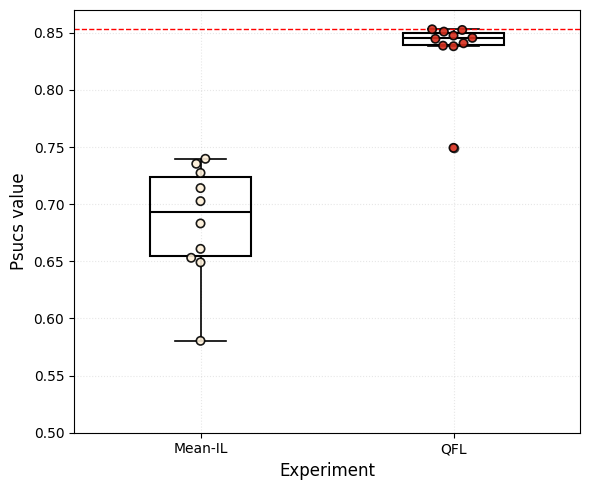

In [21]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "Psucs": mean_SCPsuc_exps_s4 + QFLPsuc_exps_s4,
    "Experiment": ["Mean-IL"] * len(mean_SCPsuc_exps_s4) + ["QFL"] * len(QFLPsuc_exps_s4)
})

plt.figure(figsize=(6, 5))

# Boxplot: hollow boxes
sns.boxplot(
    x="Experiment",
    y="Psucs",
    hue="Experiment",
    data=df,
    palette={"Mean-IL":"#fef0d9", "QFL":"#d7301f"},  # still needed for line colors
    width=0.4,
    showcaps=True,
    boxprops=dict(facecolor="none", edgecolor="black", linewidth=1.5),
    medianprops=dict(color="black", linewidth=1.5),
    whiskerprops=dict(color="black", linewidth=1.2),
    capprops=dict(color="black", linewidth=1.2),
    dodge=False,
    showfliers=True,
    legend=False
)

# Overlay actual points: hollow circles
sns.swarmplot(
    x="Experiment",
    y="Psucs",
    data=df,
    hue="Experiment",
    palette={"Mean-IL":"#fef0d9", "QFL":"#d7301f"},
    dodge=False,
    size=6,
    edgecolor="black",
    facecolor="none",
    linewidth=1.2,
    alpha=0.9,
    legend=False
)

# Reference line
plt.axhline(y=0.8536, color='r', linestyle='--', linewidth=1)

plt.ylim(0.5, 0.87)
plt.xlabel("Experiment", fontsize=12)
plt.ylabel("Psucs value", fontsize=12)
# plt.title("Quantum Computer's Mean Psucs Setup 4 for σ=4.0", fontsize=13)
plt.tight_layout()
plt.grid(True, linestyle=":", alpha=0.3)
plt.savefig("BSC_QC_sigma4.png", dpi=600, bbox_inches="tight")
plt.show()

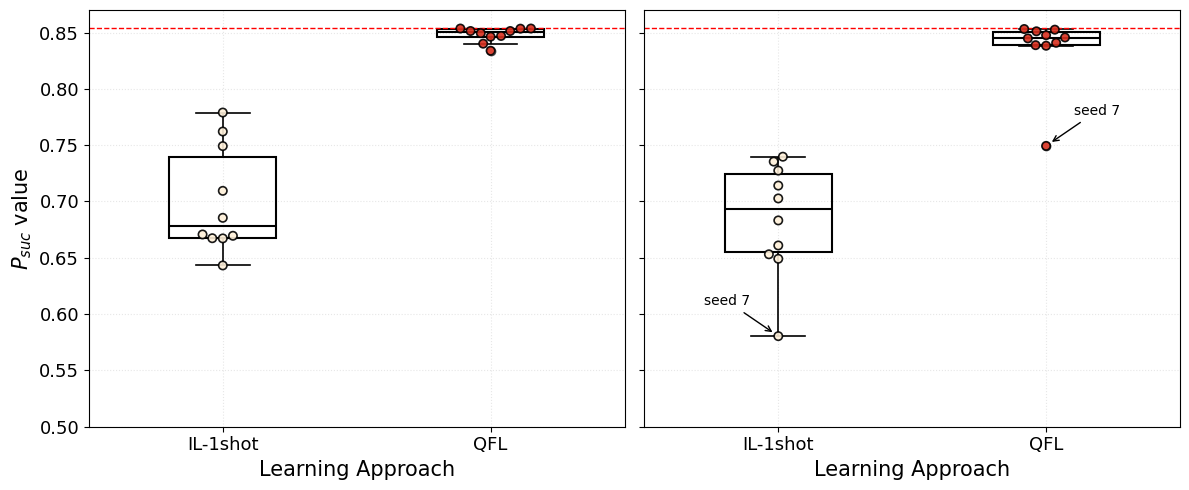

In [39]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data
df0 = pd.DataFrame({
    "Psucs": mean_SCPsuc_exps_s0 + QFLPsuc_exps_s0,
    "Experiment": ["IL-1shot"] * len(mean_SCPsuc_exps_s0) + ["QFL"] * len(QFLPsuc_exps_s0)
})

df4 = pd.DataFrame({
    "Psucs": mean_SCPsuc_exps_s4 + QFLPsuc_exps_s4,
    "Experiment": ["IL-1shot"] * len(mean_SCPsuc_exps_s4) + ["QFL"] * len(QFLPsuc_exps_s4)
})

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot 1: sigma=0
sns.boxplot(
    x="Experiment",
    y="Psucs",
    hue="Experiment",
    data=df0,
    palette={"IL-1shot":"#fef0d9", "QFL":"#d7301f"},
    width=0.4,
    showcaps=True,
    boxprops=dict(facecolor="none", edgecolor="black", linewidth=1.5),
    medianprops=dict(color="black", linewidth=1.5),
    whiskerprops=dict(color="black", linewidth=1.2),
    capprops=dict(color="black", linewidth=1.2),
    dodge=False,
    showfliers=True,
    legend=False,
    ax=axes[0]
)

sns.swarmplot(
    x="Experiment",
    y="Psucs",
    data=df0,
    hue="Experiment",
    palette={"IL-1shot":"#fef0d9", "QFL":"#d7301f"},
    dodge=False,
    size=6,
    edgecolor="black",
    facecolor="none",
    linewidth=1.2,
    alpha=0.9,
    legend=False,
    ax=axes[0]
)

axes[0].axhline(y=0.8536, color='r', linestyle='--', linewidth=1)
axes[0].set_ylim(0.5, 0.87)
axes[0].set_xlabel("Learning Approach", fontsize=15)
axes[0].set_ylabel("$P_{suc}$ value", fontsize=15)
axes[0].grid(True, linestyle=":", alpha=0.3)
axes[0].tick_params(axis='y', labelsize=13)
axes[0].tick_params(axis='x', labelsize=13)
# axes[0].set_title("σ=0.0", fontsize=13)

# Plot 2: sigma=4
sns.boxplot(
    x="Experiment",
    y="Psucs",
    hue="Experiment",
    data=df4,
    palette={"IL-1shot":"#fef0d9", "QFL":"#d7301f"},
    width=0.4,
    showcaps=True,
    boxprops=dict(facecolor="none", edgecolor="black", linewidth=1.5),
    medianprops=dict(color="black", linewidth=1.5),
    whiskerprops=dict(color="black", linewidth=1.2),
    capprops=dict(color="black", linewidth=1.2),
    dodge=False,
    showfliers=True,
    legend=False,
    ax=axes[1]
)

sns.swarmplot(
    x="Experiment",
    y="Psucs",
    data=df4,
    hue="Experiment",
    palette={"IL-1shot":"#fef0d9", "QFL":"#d7301f"},
    dodge=False,
    size=6,
    edgecolor="black",
    facecolor="none",
    linewidth=1.2,
    alpha=0.9,
    legend=False,
    ax=axes[1]
)
# Annotate outlier for exp7_s4 (index 6 in QFLPsuc_exps_s4)
x_out = 1                     # categorical x-position for 'QFL'
y_out = QFLPsuc_exps_s4[6]    # Psuc value for exp7_s4

axes[1].annotate(
    "seed 7",
    xy=(x_out, y_out),        # point to annotate
    xycoords="data",
    xytext=(20, 20),          # text offset in points (tweak as needed)
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=10,
    arrowprops=dict(
        arrowstyle="->",
        color="black",
        linewidth=1.0,
        shrinkB=5
    )
)
# New annotation for IL-1shot outlier (x=0) using the same seed-7 value
x_il = 0

axes[1].annotate(
    "seed 7",
    xy=(0, mean_SCPsuc_exps_s4[6]),
    xycoords="data",
    xytext=(-20, 20),  # shift left so labels don't overlap
    textcoords="offset points",
    ha="right",
    va="bottom",
    fontsize=10,
    arrowprops=dict(
        arrowstyle="->",
        color="black",
        linewidth=1.0,
        shrinkB=5
    )
)

axes[1].axhline(y=0.8536, color='r', linestyle='--', linewidth=1)
axes[1].set_xlabel("Learning Approach", fontsize=15)
axes[1].grid(True, linestyle=":", alpha=0.3)
axes[1].tick_params(axis='y', labelsize=13)
axes[1].tick_params(axis='x', labelsize=13)
# axes[1].set_title("σ=4.0", fontsize=13)

plt.tight_layout()
plt.savefig("BSC_QC_sigmas04.png", dpi=600, bbox_inches="tight")
plt.show()

In [23]:
### Outlier study

In [24]:
QFLPsuc_exps_s4

[np.float64(0.8531071384915998),
 np.float64(0.8456236786519347),
 np.float64(0.8476196952841968),
 np.float64(0.838281274771922),
 np.float64(0.8408754036849809),
 np.float64(0.8525371002697227),
 np.float64(0.7493486731006942),
 np.float64(0.8510829762911309),
 np.float64(0.8447845924468946),
 np.float64(0.8387718975301535)]

In [25]:
for exp in ["exp1_s4"]:
    averaged_theta = average_angles_modulo(data_s4[exp])
    QFL_client = Client(None, None)
    QFL_client.set_theta(averaged_theta)
    QFL_Psuc = compute_Psuccess(QFL_client)
    print(f"QFL Psuc for {exp}: {QFL_Psuc}")

QFL Psuc for exp1_s4: 0.8531071384915998
